In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import random

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
IMG_SIZE = 224
SEED = 1000
BATCH_SIZE = 16
TRAIN_DIR = '/media/rogerthattan/Toshiba/Thesis/Dataset/Train_Data'
TEST_DIR = '/media/rogerthattan/Toshiba/Thesis/Dataset/Test_Data'

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

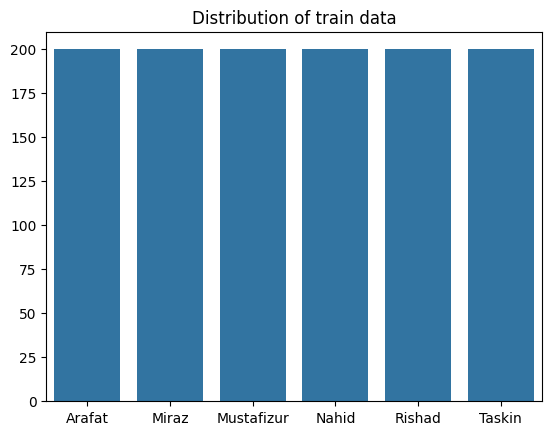

Total training examples: 1200


In [4]:
# Analyze dataset
categories = []
class_count = []
train_exm = 0
for f in os.listdir(TRAIN_DIR):
    files = os.listdir(os.path.join(TRAIN_DIR, f))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("Distribution of train data")
plt.show()
print(f"Total training examples: {train_exm}")

In [5]:
# Define enhanced data transformations with stronger augmentations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3))
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Load datasets
train_dataset = ImageFolder(root=TRAIN_DIR, transform=train_transforms)
test_dataset = ImageFolder(root=TEST_DIR, transform=test_transforms)

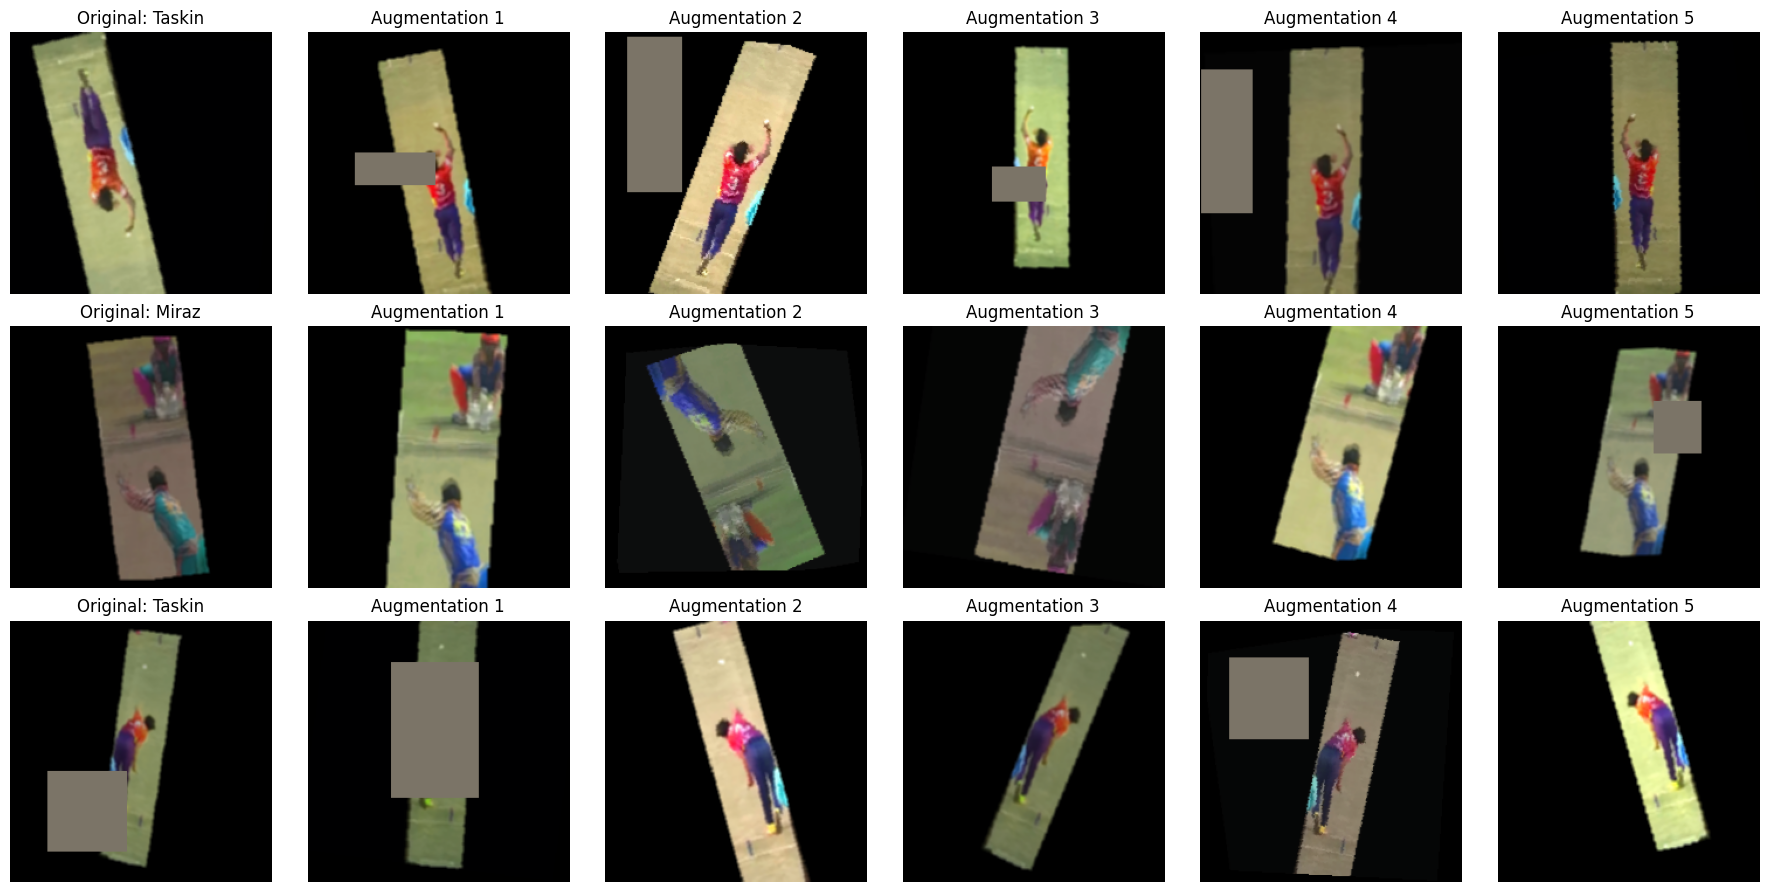

In [7]:
# Visualization function for augmentations
def visualize_augmentations(dataset, num_examples=3):
    """Visualize different augmentations applied to sample images."""
    # Get a few sample images
    samples = []
    for _ in range(num_examples):
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]
        samples.append((img, dataset.classes[label], idx))
    
    # Show each sample with 5 different augmentations
    fig, axes = plt.subplots(num_examples, 6, figsize=(18, 3*num_examples))
    
    for i, (img, class_name, idx) in enumerate(samples):
        # Denormalize image
        img_np = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        # Show original
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f"Original: {class_name}")
        axes[i, 0].axis('off')
        
        # Get original image path
        img_path = dataset.samples[idx][0]
        original_img = Image.open(img_path).convert('RGB')
        
        # Apply augmentations multiple times to same image
        for j in range(1, 6):
            aug_img = train_transforms(original_img)
            aug_np = aug_img.numpy().transpose((1, 2, 0))
            aug_np = std * aug_np + mean
            aug_np = np.clip(aug_np, 0, 1)
            
            axes[i, j].imshow(aug_np)
            axes[i, j].set_title(f"Augmentation {j}")
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the augmentations
visualize_augmentations(train_dataset)

In [8]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [9]:
# Load ResNet model
base_model = models.resnet50(weights='IMAGENET1K_V1')
print("Base model loaded")

Base model loaded


In [10]:

# Modify the classifier part
num_classes = len(categories)  # 101 food classes
num_ftrs = base_model.fc.in_features

In [11]:
# Create a new classifier with increased regularization
class FoodClassifier(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FoodClassifier, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-1])  # Remove original FC layer
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(num_ftrs, 512)
        self.dropout1 = nn.Dropout(0.3)  # Increased dropout
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)  # Increased dropout
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.3)  # Increased dropout
        self.fc4 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.base_model(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [12]:
# Create the model instance
model = FoodClassifier(base_model, num_classes)
model = model.to(device)
print(model)

# Loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Added weight decay

FoodClassifier(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [13]:
# Training function with validation
def train_model(model, criterion, optimizer, train_loader, val_loader, n_epochs=50, patience=5):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Calculate metrics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        
        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{n_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_food_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
    return history, model

Starting training...
Epoch 1/50, Train Loss: 1.4707, Train Acc: 0.4825, Val Loss: 0.4834, Val Acc: 0.9800
Epoch 2/50, Train Loss: 0.4035, Train Acc: 0.9100, Val Loss: 0.0702, Val Acc: 0.9800
Epoch 3/50, Train Loss: 0.2048, Train Acc: 0.9375, Val Loss: 0.1170, Val Acc: 0.9567
Epoch 4/50, Train Loss: 0.1718, Train Acc: 0.9600, Val Loss: 0.0071, Val Acc: 1.0000
Epoch 5/50, Train Loss: 0.1392, Train Acc: 0.9658, Val Loss: 0.0032, Val Acc: 1.0000
Epoch 6/50, Train Loss: 0.0900, Train Acc: 0.9725, Val Loss: 0.0077, Val Acc: 1.0000
Epoch 7/50, Train Loss: 0.1116, Train Acc: 0.9708, Val Loss: 0.0064, Val Acc: 0.9967
Epoch 8/50, Train Loss: 0.1318, Train Acc: 0.9625, Val Loss: 0.0029, Val Acc: 1.0000
Epoch 9/50, Train Loss: 0.0524, Train Acc: 0.9875, Val Loss: 0.0009, Val Acc: 1.0000
Epoch 10/50, Train Loss: 0.0586, Train Acc: 0.9825, Val Loss: 0.0007, Val Acc: 1.0000
Epoch 11/50, Train Loss: 0.0351, Train Acc: 0.9900, Val Loss: 0.0002, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.1073, Train Acc

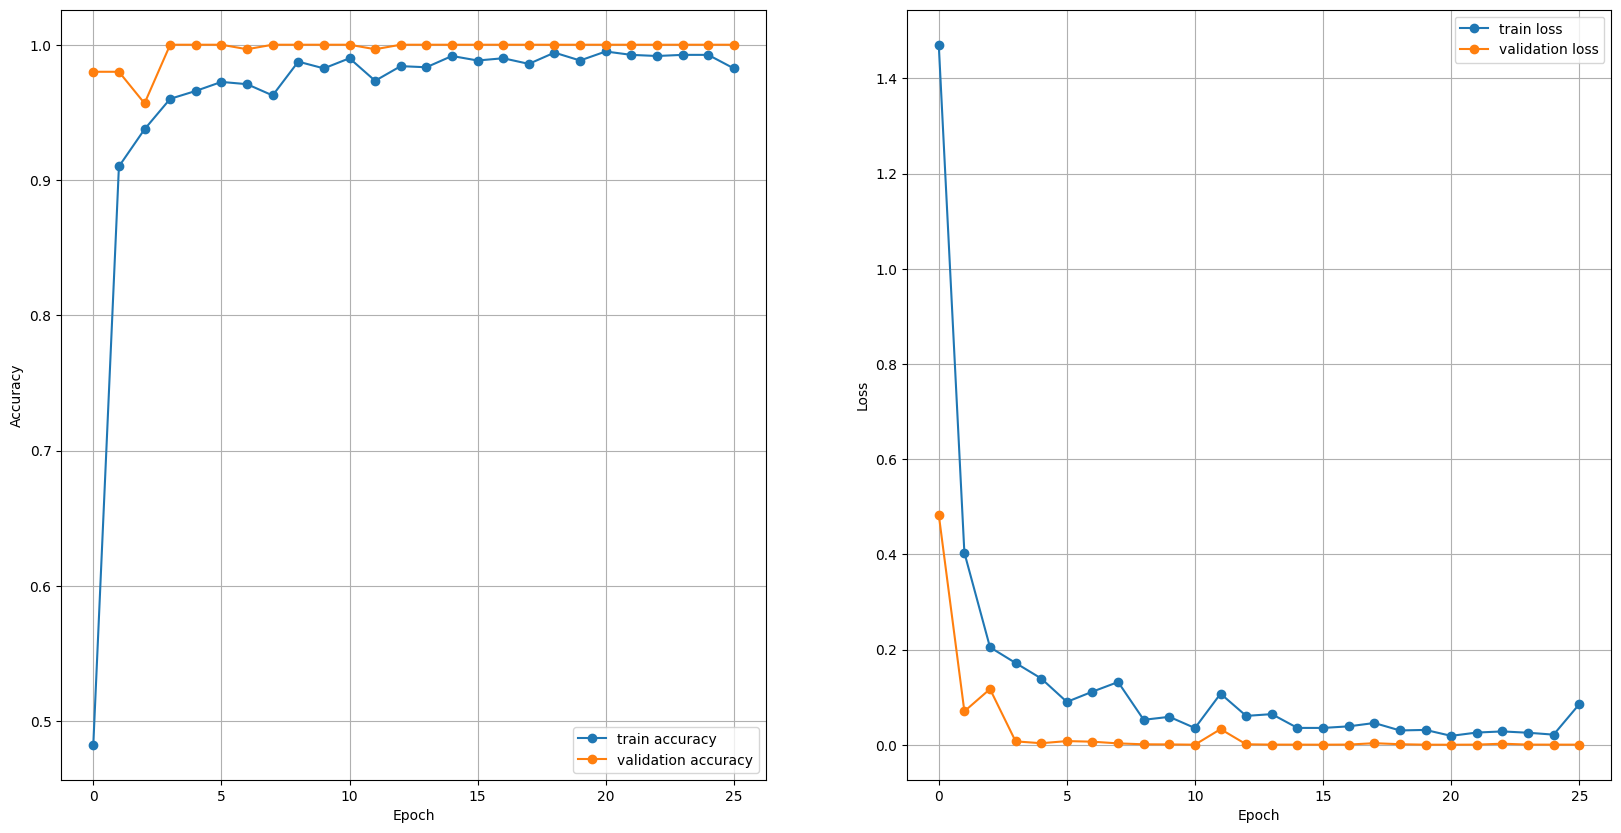

In [14]:
# Train the model
print("Starting training...")
start_time = time.time()
history, model = train_model(model, criterion, optimizer, train_loader, test_loader, n_epochs=50, patience=5)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Plot the training history
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], 'o-', label='train accuracy')
plt.plot(history['val_acc'], 'o-', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], 'o-', label='train loss')
plt.plot(history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()


In [21]:
# Comprehensive evaluation
def evaluate_model():
    # Load the best saved model
    model.load_state_dict(torch.load('best_food_model.pth'))
    model.eval()
    
    # Full evaluation on test set
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test accuracy: {test_accuracy:.4f}")
    
    # Generate classification report
    class_names = test_dataset.classes
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Generate confusion matrix (for top N classes to keep it readable)
    top_n = 10  # Adjust based on your needs
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # If too many classes, show just a subset
    if len(class_names) > top_n:
        print(f"Showing confusion matrix for top {top_n} classes (too many classes to display all)")
        plt.figure(figsize=(12, 10))
        top_indices = np.argsort(-np.sum(conf_matrix, axis=1))[:top_n]
        conf_subset = conf_matrix[top_indices][:, top_indices]
        class_subset = [class_names[i] for i in top_indices]
        sns.heatmap(conf_subset, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_subset, yticklabels=class_subset)
    else:
        plt.figure(figsize=(12, 10))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Analysis of model confidence
    confidence_scores = np.max(all_probs, axis=1)
    plt.figure(figsize=(10, 6))
    plt.hist(confidence_scores, bins=20, alpha=0.7)
    plt.xlabel('Confidence Score')
    plt.ylabel('Count')
    plt.title('Model Confidence Distribution')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Visualize some predictions
    def visualize_predictions(num_images=5):
        model.eval()
        fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(12, 15))
        
        # Get a batch of test images
        dataiter = iter(test_loader)
        images, labels = next(dataiter)
        
        with torch.no_grad():
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)
        
        # Denormalize images
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        for i in range(num_images):
            # Original image
            img = images[i].cpu().numpy().transpose((1, 2, 0))
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            # Plot image with prediction
            axes[i, 0].imshow(img)
            axes[i, 0].set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
            axes[i, 0].axis('off')
            
            # Plot confidence scores
            probs = torch.nn.functional.softmax(outputs[i], dim=0).cpu().numpy()
            top5_probs, top5_indices = torch.topk(torch.from_numpy(probs), 5)
            top5_classes = [class_names[idx] for idx in top5_indices]
            
            y_pos = np.arange(5)
            axes[i, 1].barh(y_pos, top5_probs)
            axes[i, 1].set_yticks(y_pos)
            axes[i, 1].set_yticklabels(top5_classes)
            axes[i, 1].set_title('Top 5 Predictions')
            axes[i, 1].set_xlim(0, 1)
        
        plt.tight_layout()
        plt.show()

    visualize_predictions()


--- Model Evaluation ---


/tmp/ipykernel_64043/2383591943.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_food_model.pth'))


Test accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Arafat       1.00      1.00      1.00        50
       Miraz       1.00      1.00      1.00        50
  Mustafizur       1.00      1.00      1.00        50
       Nahid       1.00      1.00      1.00        50
      Rishad       1.00      1.00      1.00        50
      Taskin       1.00      1.00      1.00        50

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



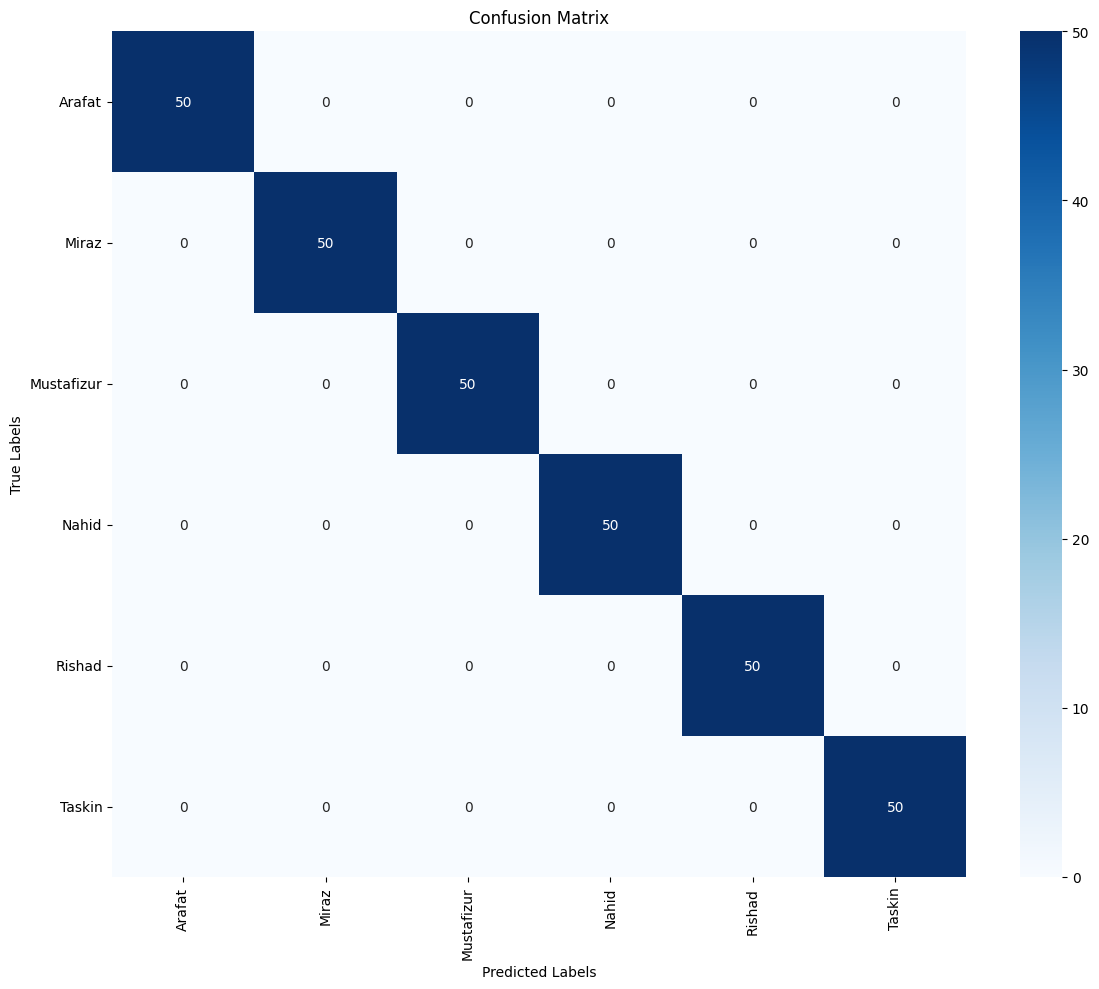

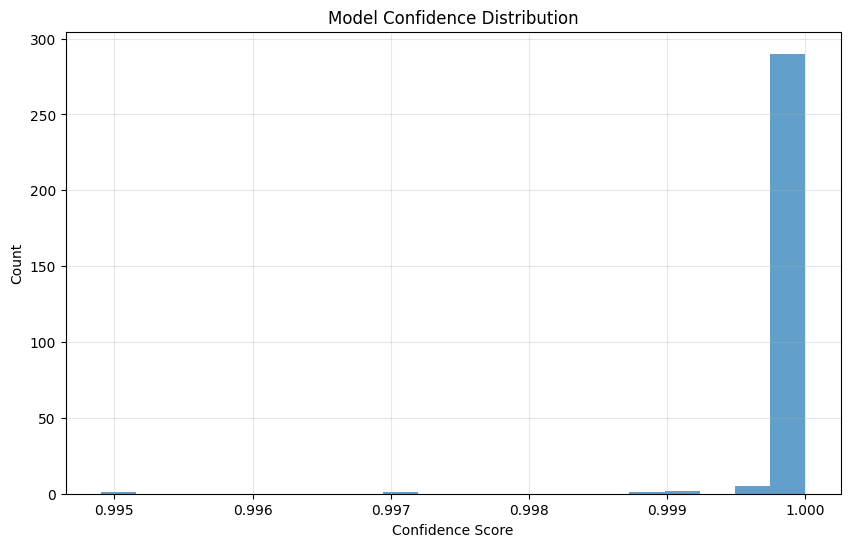

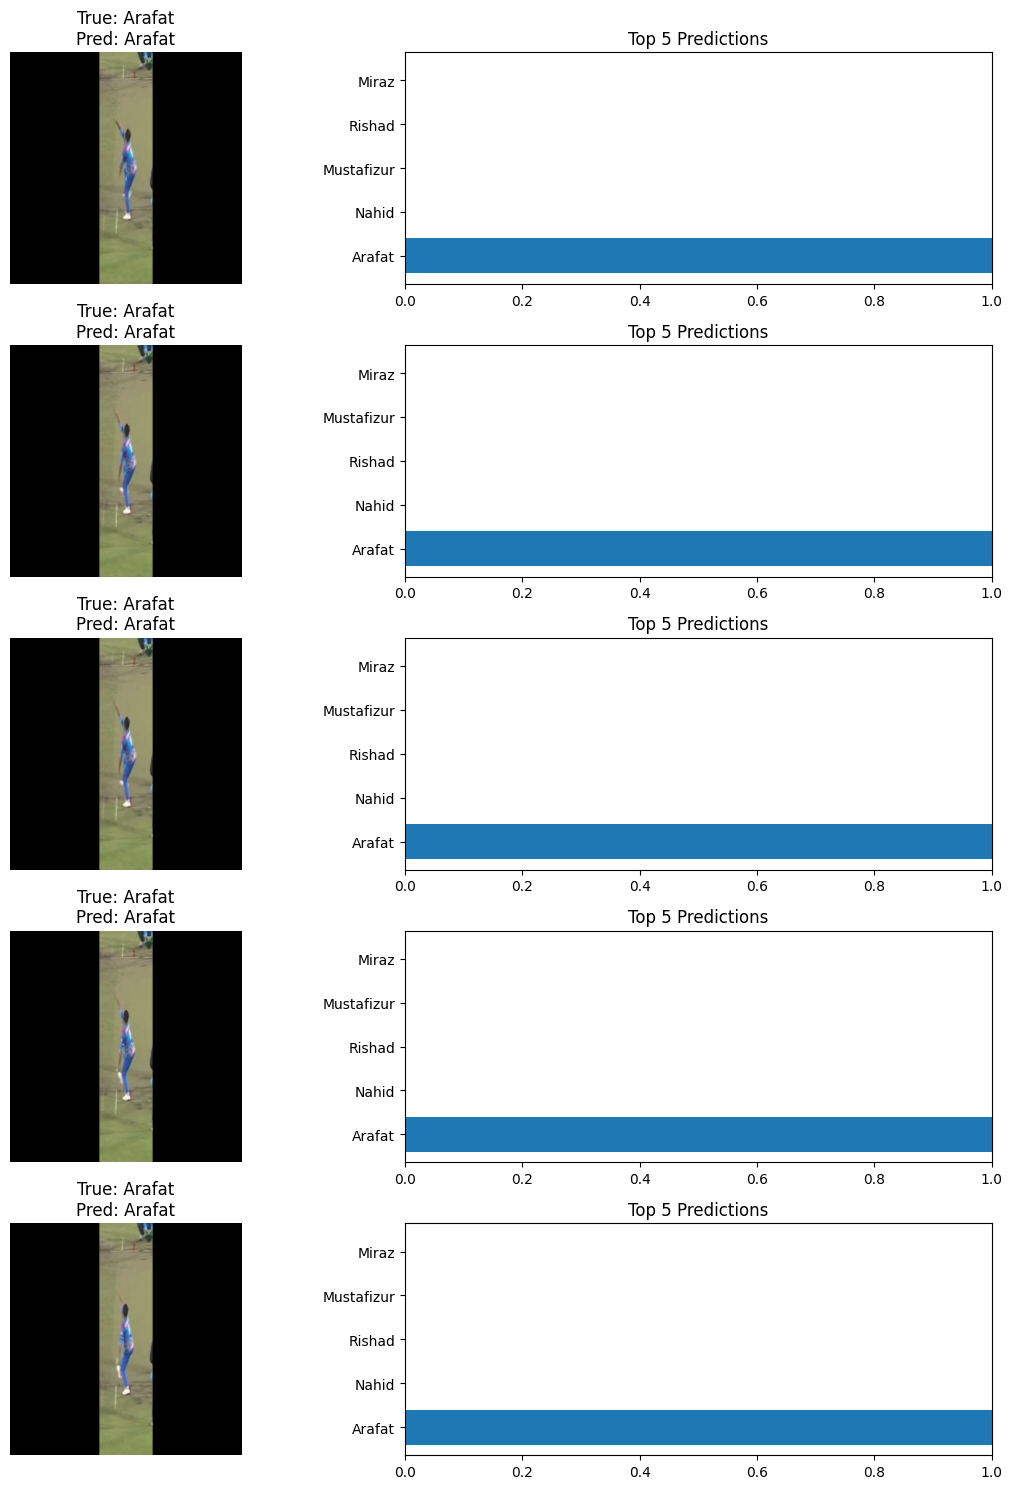

In [22]:
# Run the evaluation
print("\n--- Model Evaluation ---")
evaluate_model()